In [1]:
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import pipeline

import os
import nltk
import pandas as pd
import torch
import numpy as np
from jinja2 import Template
import pickle
from collections import defaultdict

from fuzzywuzzy import fuzz

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from util_research import *

import matplotlib.pyplot as plt
from math import log

def predictor(text_injection_instance, write_in_file=False, out_path_prefix="Text_injection_GPT2-XL_"):
    
    # prompt has the max number of tokens: 1024, and we start at a " " char.
    
    model = text_injection_instance.model
    tokenizer = text_injection_instance.tokenizer
    device = text_injection_instance.device
    chapter1 = text_injection_instance.chapter1
    chapter2_tokenized = text_injection_instance.chapter2_tokenized
    tokens_to_append = text_injection_instance.tokens_to_append

    predictions = {}
    all_result_objects = defaultdict(list)

    for item in dir_list_annotations:
        
        print(item)
        
        story_no = item[len("Andersen_story"):-len(".txt")]

        f = open(os.path.join(path_andersen, item), 'r') 
        story = f.read()
        f.close()
        
        predictions[item] = defaultdict(dict)

        if write_in_file:
            out_path = out_path_prefix + item[:-3] + "xlsx"
            writer = pd.ExcelWriter(out_path, engine='xlsxwriter')
            workbook = writer.book
            format = workbook.add_format({'text_wrap': True})

        annotations = all_annotations[item]

        paragraphs = story.split("\n\n")
        no_paragraphs = len(paragraphs)
        paragraph = paragraphs[0]
        paragraph = paragraph.replace("\n", " ")
        len_title = len(paragraph) + 2        

        i = 0 # line number in the annotation file
        j = 0 # paragraph number

        char_count = len_title   

        while i < len(annotations) and j < no_paragraphs:

            if char_count + 2 >= annotations[i][0]:

                line = annotations[i]

                character = line[1]
                gold_answer = line[2]
                grammatical_number = line[3]
                context = paragraph
                context = context.rstrip(", ;-\n")

                gold_locations = gold_answer.split("/")
                my_dic = {"Prompts": [gold_answer, "-", "-", "-"]}

                for k in range(1, num_llama_templates+1):#range(1, num_templates+1):
                    
                    print(k)

                    y = char_count
                    x = y - 2600

                    if x < len_title:
                        text = story[len_title:y]

                    else:
                        x = story[x:y].find(" ") + x
                        text = story[x:y]

                    text = text_clean_ending(text)
                    text = remove_new_lines(text)

                    for num_chap2_tokens in tokens_to_append:
                        chapter2_part = tokenizer.decode(chapter2_tokenized[:num_chap2_tokens], skip_special_tokens=True)
                        chapter2_part = chapter2_part.rstrip(", ;-\n")
                        context = text + "\n" + chapter2_part
                        prompt = gpt2_prompt_generator(tokenizer, k, context, character, grammatical_number, 1004)
                        
                        """inputs = tokenizer.encode(prompt, return_tensors="pt")
                        inputs = inputs.to(device)
                        with torch.no_grad():
                            outputs = model.generate(inputs)
                        out = tokenizer.decode(outputs[0], skip_special_tokens=True)"""
                        
                        """out = model(prompt, max_new_tokens=40, num_return_sequences=1)[0]["generated_text"]
                        if out[:len(prompt)] == prompt:
                            out = out[len(prompt)+1:]"""
                        
                        inputs = tokenizer(prompt, return_tensors="pt")                
                        inputs = inputs.to(device)
                        with torch.no_grad():
                            outputs = model(**inputs)
                        my_list = []

                        for dec_i in range(20):
                            logits = outputs.logits
                            past = outputs.past_key_values
                            new_input_id = logits.argmax(dim=2)[0][-1]
                            if new_input_id.item() == tokenizer.encode(tokenizer.eos_token)[0] and dec_i != 0:
                                break
                            new_input_id = new_input_id.unsqueeze(0).unsqueeze(0)
                            my_list.append(new_input_id)
                            with torch.no_grad():
                                outputs = model(input_ids=new_input_id, past_key_values=past)

                        out = tokenizer.decode(torch.cat((my_list)).squeeze())
                        
                        ind = out.find(".")
                        out_to_match = out[:ind]
                        match1, match2 = exactly_or_fuzzily_matched(out_to_match, gold_locations)
                        predictions[item][k][num_chap2_tokens] = out
                        result_object = TextInjectionResults(prompt, out, gold_locations, character, k, num_chap2_tokens, story_no, match1, match2)
                        all_result_objects[k].append(result_object)
                        if write_in_file:
                            my_dic[prompt] = [out, num_chap2_tokens, match1, match2]

                if write_in_file:
                    df = pd.DataFrame(data=my_dic, index=["output", "num_tokens_appended", "exact match?", "fuzzy match?"])
                    df = (df.T)
                    df.to_excel(writer, sheet_name=str(i+1))
                    worksheet = writer.sheets[str(i+1)]
                    for idx, col in enumerate(df):
                        max_len = 75
                        worksheet.set_column(idx, idx, max_len, format)

                i += 1
                print("line:", i)
            else:

                j += 1
                paragraph = paragraphs[j]
                paragraph = paragraph.replace("\n", " ")
                char_count += (len(paragraph) + 2)

        if write_in_file:
            writer.save()

    return predictions, all_result_objects

all_annotations = {}

for item in dir_list_annotations:
    
    f = open(os.path.join(path_annotations, item), 'r')
    annotations = pd.read_csv(f, sep="\t")
    annotations = annotations.values
    f.close()
    
    all_annotations[item] = annotations
    
class TextInjection():
    def __init__(self, model, tokenizer, device, chapter1, chapter2, tokens_to_append):
        self.model = model
        self.tokenizer = tokenizer
        #self.model = self.model.to(device)
        self.device = device
        self.chapter1 = chapter1
        self.chapter2_tokenized = tokenizer.encode(chapter2)
        self.tokens_to_append = tokens_to_append
        
class TextInjectionResults():
    def __init__(self, prompt, model_out, gold_locations, character, k, tokens_appended, story_no, exact_match, fuzzy_match):
        self.prompt = prompt
        self.model_out = model_out
        self.gold_locations = gold_locations
        self.character = character
        self.k = k
        self.tokens_appended = tokens_appended
        self.story_no = story_no
        self.exact_match = exact_match
        self.fuzzy_match = fuzzy_match

path = "/scratch/users/bozyurt20/hpc_run/litbank/original/105_persuasion.txt"

with open(path, "r") as f:
    book = f.read()
    
indices = []
for i in range(1, 100):
    chapter_header = "Chapter " + str(i) + "\n\n"
    indices.append(book.find(chapter_header))

ind1 = indices[0]
ind2 = indices[1]
i = 2
chapters = []
while ind2 != -1:
    chapters.append(book[ind1:ind2])
    ind1 = ind2
    ind2 = indices[i]
    i += 1   
    



/kuacc/users/bozyurt20/.conda/envs/hf/lib/python3.8/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
tokenizer = GPT2Tokenizer.from_pretrained("gpt2-xl")

In [3]:
model = GPT2LMHeadModel.from_pretrained("gpt2-xl")

In [4]:
model = model.to(device)

In [ ]:
#model = pipeline('text-generation', model='gpt2-xl')#, device=0)

tokens_to_append = [x for x in range(0, 1001, 40)]

chapter1 = remove_new_lines(chapters[0])
paragraph_start_ind = chapters[1].find("Mr Shepherd")
chapter2 = remove_new_lines(chapters[1][paragraph_start_ind:])

text_injection_instance = TextInjection(model, tokenizer, device, chapter1, chapter2, tokens_to_append)

predictions, all_result_objects = predictor(text_injection_instance, write_in_file=False, out_path_prefix="Text_injection_GPT2-XL_")

with open("Text_injection_GPT2-XL_predictions.txt", "wb") as f:
    pickle.dump(predictions, f)
    
with open("Text_injection_GPT2-XL_all_result_objects.txt", "wb") as f:
    pickle.dump(all_result_objects, f)

Token indices sequence length is longer than the specified maximum sequence length for this model (2409 > 1024). Running this sequence through the model will result in indexing errors


Andersen_story2.txt
1
2
3
line: 1
1
2
3
line: 2
1
2
3
line: 3
1
2
3
line: 4
1
2
3
line: 5
1
2
3
line: 6
1
2
3
line: 7
1
2
3
line: 8
1
2
3
line: 9
1
2
3
line: 10
1
2
3
line: 11
1
2
3
line: 12
1
2
3
line: 13
1
2
3
line: 14
1
2
3
line: 15
1
2
3
line: 16
1
2
3
line: 17
1
2
3
line: 18
Andersen_story17.txt
1
2
3
line: 1
1
2
3
line: 2
1
2
3
line: 3
1
2
3
line: 4
1
2
3
line: 5
1
2
3
line: 6
1
2
3
line: 7
1
2
3
line: 8
1
2
3
line: 9
1
2
3
line: 10
Andersen_story3.txt
1
2
3
line: 1
1
2
3
line: 2
1
2
3
line: 3
1
2
3
line: 4
1
2
3
line: 5
1
2
3
line: 6
Andersen_story9.txt
1
2
3
line: 1
1
2
3
line: 2
1
2
3
line: 3
1
2
3
line: 4
1
2
3
line: 5
1
2
3
line: 6
1
2
3
line: 7
1
2
3
line: 8
1
2
3
line: 9
1
2
3
line: 10
1
2
3
line: 11
1
2
3
line: 12
1
2
3
line: 13
1
2
3
line: 14
Andersen_story18.txt
1
2
3
line: 1
1


In [91]:
len(all_result_objects[1])

6474

In [6]:
2+2

4

# Get the Results

In [7]:
with open("Text_injection_GPT2-XL_predictions.txt", "rb") as f:
    predictions = pickle.load(f)

In [8]:
with open("Text_injection_GPT2-XL_all_result_objects.txt", "rb") as f:
    all_result_objects = pickle.load(f)

# Distance Graph

In [9]:
exact_match_distances = {}
fuzzy_match_distances = {}
non_exact_match_distances = {}
non_fuzzy_match_distances = {}

number_of_questions_asked = {}
not_in_context = {}
for k in all_result_objects.keys():

    exact_match_distances[k] = []
    fuzzy_match_distances[k] = []
    non_exact_match_distances[k] = []
    non_fuzzy_match_distances[k] = []

    #for num_chap2_tokens in all_result_objects[k].keys():
    number_of_questions_asked[k] = 0
        
    for result_object in all_result_objects[k]: #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        
        number_of_questions_asked[k] += 1

        distances = [1e9 for _ in range(len(gold_locations))]

        for num_loc, gold_location in enumerate(gold_locations):
            loc_mention = prompt.rfind(gold_location)
            if loc_mention != -1:
                loc_mention += len(gold_location)
                no_tokens = len(tokenizer.encode(prompt[loc_mention:]))
                #abs_inv_recency = len(prompt) - loc_mention
                #distances[num_loc] = abs_inv_recency
                distances[num_loc] = no_tokens
                
        if min(distances) < 1e8:
            
            if match1 == "Yes":
                exact_match_distances[k].append(min(distances))
            else:
                non_exact_match_distances[k].append(min(distances))

            if match2 == "Yes":
                fuzzy_match_distances[k].append(min(distances))
            else:                     
                non_fuzzy_match_distances[k].append(min(distances))

In [11]:
prompt_no = 1
loc_mention_graph = []

for dist in exact_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 1))
    
for dist in non_exact_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 0))

In [12]:
sum(exact_match_distances[prompt_no])/len(exact_match_distances[prompt_no])

ZeroDivisionError: division by zero

In [13]:
len(exact_match_distances[prompt_no])

0

In [14]:
sum(non_exact_match_distances[prompt_no])/len(non_exact_match_distances[prompt_no])

502.7812431842966

In [15]:
len(non_exact_match_distances[prompt_no])

4585

In [16]:
all_distances = [x[0] for x in loc_mention_graph]

In [17]:
all_distances = sorted(all_distances)

In [18]:
min(all_distances)

2

In [19]:
all_distances[-1]

1000

In [20]:
grap = defaultdict(list)
num_data_points = {}
for tupl in loc_mention_graph:
    for i in range(10):
        if 100*i<=tupl[0]<100*i+100:
            grap[i].append(tupl)
for i in range(10):
    num_data_points[i] = len(grap[i])
    if len(grap[i]) != 0 and len(grap[i]) > 5:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]

In [21]:
grap_tuples

[(0, 0.0),
 (1, 0.0),
 (2, 0.0),
 (3, 0.0),
 (4, 0.0),
 (5, 0.0),
 (6, 0.0),
 (7, 0.0),
 (8, 0.0),
 (9, 0.0)]

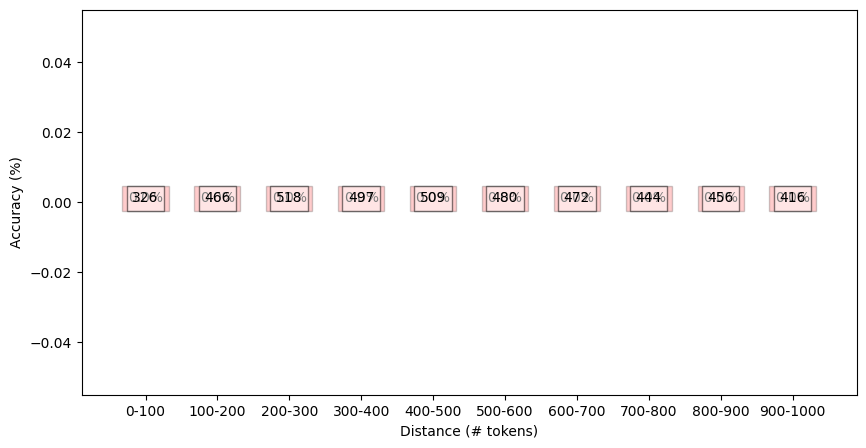

In [22]:
x_points, y_points = zip(*grap_tuples)
plt.figure(figsize = (10, 5))
plt.bar(x_points, y_points, color="orange")
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i], str(round(y_points[i],2)) + "%", ha = 'center', bbox = dict(facecolor = 'red', alpha =.2))
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i]//2, num_data_points[i],  ha = 'center',
             bbox = dict(facecolor = 'white', alpha = .5))
plt.xlabel("Distance (# tokens)")
plt.ylabel("Accuracy (%)")

plt.xticks(np.arange(10), ['0-100', '100-200', '200-300', '300-400', "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000"])
plt.savefig('T0pp_exact.png')

In [23]:
x_points

(0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [24]:
exact_matches = {}

for k in all_result_objects.keys():
    exact_matches[k] = []
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        
        if match1 == "Yes":
            exact_matches[k].append(1)
        else:
            exact_matches[k].append(0)
            

In [25]:
accuracies = {}
for k in all_result_objects.keys():
    if exact_matches[k] != []:
        accuracies[k] = sum(exact_matches[k])/len(exact_matches[k])

In [26]:
accuracies

{1: 0.0, 2: 0.00030892801977139327, 3: 0.0}

In [27]:
exact_matches = {}

for k in all_result_objects.keys():
    exact_matches[k] = {}
    
    for no_tok in tokens_to_append:
        exact_matches[k][no_tok] = []
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        no_tok = result_object.tokens_appended

        if match1 == "Yes":
            exact_matches[k][no_tok].append(1)
        else:
            exact_matches[k][no_tok].append(0)



In [28]:
accuracies_no_tok_appended = {}
for k in all_result_objects.keys():
    accuracies_no_tok_appended[k] = {}
    for no_tok in exact_matches[k]:
        if exact_matches[k][no_tok] != []:
            accuracies_no_tok_appended[k][no_tok] = sum(exact_matches[k][no_tok])/len(exact_matches[k][no_tok])

In [29]:
for k in all_result_objects.keys():
    
    if accuracies_no_tok_appended[k]:
        print(k)
        print(accuracies_no_tok_appended[k])

1
{0: 0.0, 40: 0.0, 80: 0.0, 120: 0.0, 160: 0.0, 200: 0.0, 240: 0.0, 280: 0.0, 320: 0.0, 360: 0.0, 400: 0.0, 440: 0.0, 480: 0.0, 520: 0.0, 560: 0.0, 600: 0.0, 640: 0.0, 680: 0.0, 720: 0.0, 760: 0.0, 800: 0.0, 840: 0.0, 880: 0.0, 920: 0.0, 960: 0.0, 1000: 0.0}
2
{0: 0.0, 40: 0.0, 80: 0.0, 120: 0.0, 160: 0.0, 200: 0.0, 240: 0.0, 280: 0.0, 320: 0.0, 360: 0.0, 400: 0.0, 440: 0.0, 480: 0.0, 520: 0.0, 560: 0.0, 600: 0.008032128514056224, 640: 0.0, 680: 0.0, 720: 0.0, 760: 0.0, 800: 0.0, 840: 0.0, 880: 0.0, 920: 0.0, 960: 0.0, 1000: 0.0}
3
{0: 0.0, 40: 0.0, 80: 0.0, 120: 0.0, 160: 0.0, 200: 0.0, 240: 0.0, 280: 0.0, 320: 0.0, 360: 0.0, 400: 0.0, 440: 0.0, 480: 0.0, 520: 0.0, 560: 0.0, 600: 0.0, 640: 0.0, 680: 0.0, 720: 0.0, 760: 0.0, 800: 0.0, 840: 0.0, 880: 0.0, 920: 0.0, 960: 0.0, 1000: 0.0}


In [31]:
prompt_no = 1
loc_mention_graph = []

for dist in fuzzy_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 1))
    
for dist in non_fuzzy_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 0))

In [32]:
sum(fuzzy_match_distances[prompt_no])/len(fuzzy_match_distances[prompt_no])

375.63380281690144

In [33]:
len(fuzzy_match_distances[prompt_no])

71

In [34]:
sum(non_fuzzy_match_distances[prompt_no])/len(non_fuzzy_match_distances[prompt_no])

504.7811253876828

In [35]:
len(non_fuzzy_match_distances[prompt_no])

4514

In [36]:
all_distances = [x[0] for x in loc_mention_graph]

In [37]:
all_distances = sorted(all_distances)

In [38]:
min(all_distances)

2

In [39]:
all_distances[-1]

1000

In [40]:
grap = defaultdict(list)
num_data_points = {}
for tupl in loc_mention_graph:
    for i in range(10):
        if 100*i<=tupl[0]<100*i+100:
            grap[i].append(tupl)
for i in range(10):
    num_data_points[i] = len(grap[i])
    if len(grap[i]) != 0 and len(grap[i]) > 5:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]

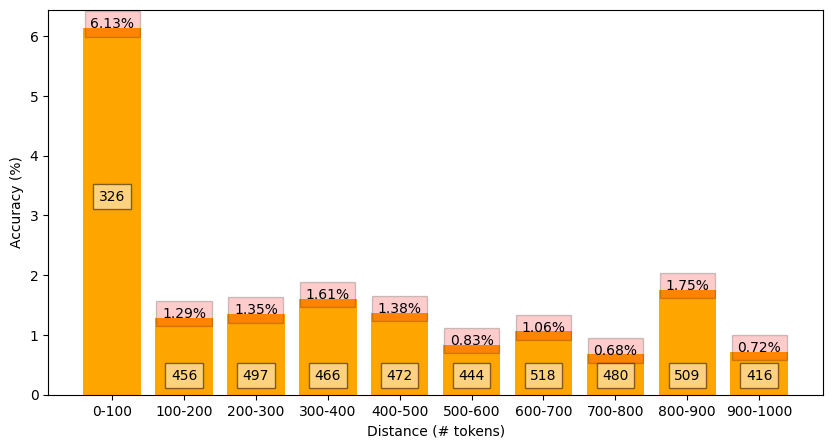

In [44]:
x_points, y_points = zip(*grap_tuples)
plt.figure(figsize = (10, 5))
plt.bar(x_points, y_points, color="orange")
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i], str(round(y_points[i],2)) + "%", ha = 'center', bbox = dict(facecolor = 'red', alpha =.2))
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i]//2 + 0.25, num_data_points[i],  ha = 'center',
             bbox = dict(facecolor = 'white', alpha = .5))
plt.xlabel("Distance (# tokens)")
plt.ylabel("Accuracy (%)")

plt.xticks(np.arange(10), ['0-100', '100-200', '200-300', '300-400', "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000"])
plt.savefig('gpt2xl_fuzzy.png')

In [72]:
prompt_no = 2
loc_mention_graph = []

for dist in fuzzy_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 1))
    
for dist in non_fuzzy_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 0))

In [73]:
grap = defaultdict(list)
num_data_points = {}
for tupl in loc_mention_graph:
    for i in range(10):
        if 100*i<=tupl[0]<100*i+100:
            grap[i].append(tupl)
for i in range(10):
    num_data_points[i] = len(grap[i])
    if len(grap[i]) != 0 and len(grap[i]) > 5:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]
grap_tuples = sorted(grap_tuples, key=lambda x: x[0])

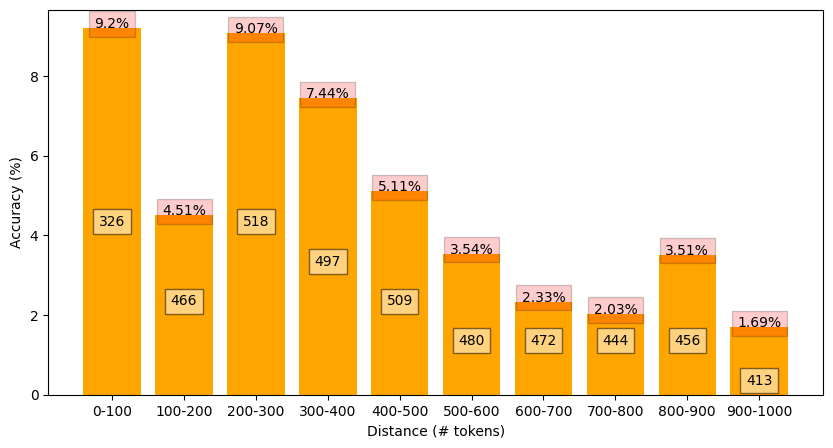

In [74]:
x_points, y_points = zip(*grap_tuples)
plt.figure(figsize = (10, 5))
plt.bar(x_points, y_points, color="orange")
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i], str(round(y_points[i],2)) + "%", ha = 'center', bbox = dict(facecolor = 'red', alpha =.2))
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i]//2 + 0.25, num_data_points[i],  ha = 'center',
             bbox = dict(facecolor = 'white', alpha = .5))
plt.xlabel("Distance (# tokens)")
plt.ylabel("Accuracy (%)")

plt.xticks(np.arange(10), ['0-100', '100-200', '200-300', '300-400', "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000"])
plt.savefig('gpt2xl_fuzzy_2.png')

In [80]:
with open("Text_injection_t5_base_graph_points.txt", "rb") as f:
    grap_tuples_t5 = pickle.load(f)

In [76]:
with open("Text_injection_T0pp_graph_points.txt", "rb") as f:
    grap_tuples_t0pp = pickle.load(f)

In [62]:
x_points

(2, 0, 4, 5, 9, 1, 3, 8, 7, 6)

In [81]:
grap_tuples

[(0, 9.202453987730062),
 (1, 4.506437768240343),
 (2, 9.073359073359073),
 (3, 7.44466800804829),
 (4, 5.1080550098231825),
 (5, 3.5416666666666665),
 (6, 2.330508474576271),
 (7, 2.027027027027027),
 (8, 3.508771929824561),
 (9, 1.694915254237288)]

In [82]:
grap_tuples_t5

[(1, 16.8141592920354),
 (2, 15.298507462686567),
 (0, 13.333333333333334),
 (3, 7.936507936507936),
 (4, 4.792332268370607),
 (5, 0.0),
 (6, 0),
 (7, 0),
 (8, 0),
 (9, 0)]

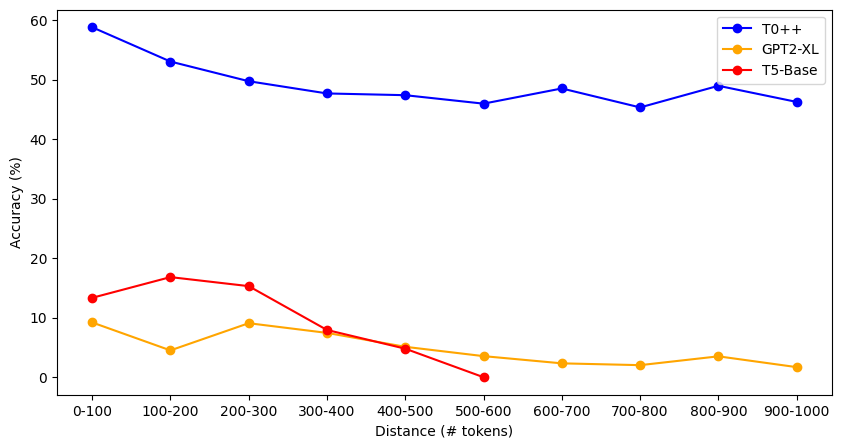

In [84]:
grap_tuples_t5 = sorted(grap_tuples_t5, key=lambda x: x[0])
grap_tuples_t0pp = sorted(grap_tuples_t0pp, key=lambda x: x[0])
x_t5, y_t5 = zip(*grap_tuples_t5)
x_t0pp, y_t0pp = zip(*grap_tuples_t0pp)
x_points, y_points = zip(*grap_tuples)
plt.figure(figsize = (10, 5))
plt.plot(x_t0pp, y_t0pp, color="blue", marker='o', label="T0++")
plt.plot(x_points, y_points, color="orange", marker='o', label="GPT2-XL")
plt.plot(x_t5[:6], y_t5[:6], color="red", marker='o', label="T5-Base")

"""for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i], str(round(y_points[i],2)) + "%", ha = 'center', bbox = dict(facecolor = 'red', alpha =.2))
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i]//2 + 0.25, num_data_points[i],  ha = 'center',
             bbox = dict(facecolor = 'white', alpha = .5))"""
plt.xlabel("Distance (# tokens)")
plt.ylabel("Accuracy (%)")
plt.legend(loc="upper right")
plt.xticks(np.arange(10), ['0-100', '100-200', '200-300', '300-400', "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000"])
plt.savefig('3models.png')

In [48]:
prompt_no = 3
loc_mention_graph = []

for dist in fuzzy_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 1))
    
for dist in non_fuzzy_match_distances[prompt_no]:
    loc_mention_graph.append((dist, 0))

In [49]:
grap = defaultdict(list)
num_data_points = {}
for tupl in loc_mention_graph:
    for i in range(10):
        if 100*i<=tupl[0]<100*i+100:
            grap[i].append(tupl)
for i in range(10):
    num_data_points[i] = len(grap[i])
    if len(grap[i]) != 0 and len(grap[i]) > 5:
        grap[i] = sum([tupl[1] == 1 for tupl in grap[i]]) / len(grap[i]) * 100
    else:
        grap[i] = 0
grap_tuples = [(key, grap[key]) for key in grap]

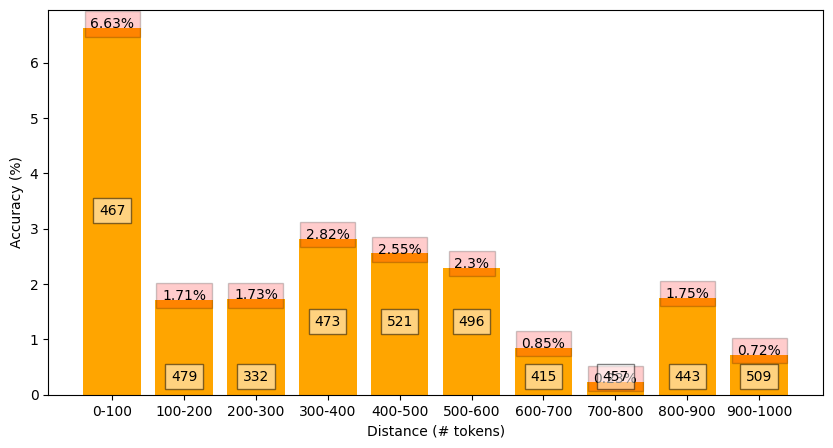

In [50]:
x_points, y_points = zip(*grap_tuples)
plt.figure(figsize = (10, 5))
plt.bar(x_points, y_points, color="orange")
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i], str(round(y_points[i],2)) + "%", ha = 'center', bbox = dict(facecolor = 'red', alpha =.2))
for i in range(len(x_points)):
    plt.text(x_points[i], y_points[i]//2 + 0.25, num_data_points[i],  ha = 'center',
             bbox = dict(facecolor = 'white', alpha = .5))
plt.xlabel("Distance (# tokens)")
plt.ylabel("Accuracy (%)")

plt.xticks(np.arange(10), ['0-100', '100-200', '200-300', '300-400', "400-500", "500-600", "600-700", "700-800", "800-900", "900-1000"])
plt.savefig('gpt2xl_fuzzy_3.png')

In [51]:
fuzzy_matches = {}

for k in all_result_objects.keys():
    fuzzy_matches[k] = []
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        
        if match2 == "Yes":
            fuzzy_matches[k].append(1)
        else:
            fuzzy_matches[k].append(0)
            

In [52]:
accuracies = {}
for k in all_result_objects.keys():
    if fuzzy_matches[k] != []:
        accuracies[k] = sum(fuzzy_matches[k])/len(fuzzy_matches[k])

In [53]:
accuracies

{1: 0.013438368860055607, 2: 0.03954278653073834, 3: 0.018072289156626505}

In [50]:
fuzzy_matches = {}

for k in all_result_objects.keys():
    fuzzy_matches[k] = {}
    
    for no_tok in tokens_to_append:
        fuzzy_matches[k][no_tok] = []
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        no_tok = result_object.tokens_appended

        if match2 == "Yes":
            fuzzy_matches[k][no_tok].append(1)
        else:
            fuzzy_matches[k][no_tok].append(0)



In [51]:
accuracies_no_tok_appended = {}
for k in all_result_objects.keys():
    accuracies_no_tok_appended[k] = {}
    for no_tok in exact_matches[k]:
        if fuzzy_matches[k][no_tok] != []:
            accuracies_no_tok_appended[k][no_tok] = sum(fuzzy_matches[k][no_tok])/len(fuzzy_matches[k][no_tok])

In [52]:
for k in all_result_objects.keys():
    
    if accuracies_no_tok_appended[k]:
        print(k)
        print(accuracies_no_tok_appended[k])

6
{0: 0.46586345381526106, 50: 0.3373493975903614, 100: 0.4497991967871486, 150: 0.46184738955823296, 200: 0.43373493975903615, 250: 0.4538152610441767, 300: 0.40160642570281124, 400: 0.4497991967871486, 500: 0.40562248995983935, 600: 0.3855421686746988, 700: 0.3172690763052209, 800: 0.3855421686746988}
10
{0: 0.44176706827309237, 50: 0.40562248995983935, 100: 0.3895582329317269, 150: 0.3453815261044177, 200: 0.36947791164658633, 250: 0.3534136546184739, 300: 0.3413654618473896, 400: 0.40963855421686746, 500: 0.3534136546184739, 600: 0.3855421686746988, 700: 0.24096385542168675, 800: 0.28112449799196787}
13
{0: 0.4859437751004016, 50: 0.5020080321285141, 100: 0.4738955823293173, 150: 0.4578313253012048, 200: 0.4779116465863454, 250: 0.4738955823293173, 300: 0.46184738955823296, 400: 0.4738955823293173, 500: 0.43775100401606426, 600: 0.4578313253012048, 700: 0.3855421686746988, 800: 0.44176706827309237}
17
{0: 0.4738955823293173, 50: 0.46586345381526106, 100: 0.46184738955823296, 150: 0

# Visualization

In [10]:
with open("Text_injection_T0pp_all_result_objects.txt", "rb") as f:
    all_result_objects = pickle.load(f)

In [13]:
for k in [13]: #all_result_objects.keys():
    
    out_path = "text_injection_t0pp_outputs_k" + str(k) + ".xlsx"
    writer = pd.ExcelWriter(out_path, engine='xlsxwriter')
    workbook = writer.book
    format = workbook.add_format({'text_wrap': True})
    my_dic = {"Prompts": ["-", "-", "-", "-", "-"]}
    
    for j, result_object in enumerate(all_result_objects[k]): #[num_chap2_tokens]:

        prompt = result_object.prompt
        out = result_object.model_out
        gold_locations = result_object.gold_locations
        match1 = result_object.exact_match
        match2 = result_object.fuzzy_match
        num_chap2_tokens = result_object.tokens_appended
        
        my_dic[prompt] = [gold_locations, out, num_chap2_tokens, match1, match2]
        
    df = pd.DataFrame(data=my_dic, index=["gold_locations", "output", "num_tokens_appended", "exact match?", "fuzzy match?"])
    df = (df.T)
    df.to_excel(writer, sheet_name="output")
    worksheet = writer.sheets["output"]
    for idx, col in enumerate(df):
        max_len = 75
        worksheet.set_column(idx, idx, max_len, format)

    writer.save()



/tmp/ipykernel_17369/2041282757.py:28: FutureWarning: save is not part of the public API, usage can give unexpected results and will be removed in a future version
  writer.save()


In [1]:
from transformers import T5ForConditionalGeneration, AutoTokenizer
import torch

In [2]:
model = T5ForConditionalGeneration.from_pretrained("google/flan-ul2", device_map="auto", load_in_8bit=True)     


===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
CUDA SETUP: CUDA runtime path found: /kuacc/users/bozyurt20/.conda/envs/hf/lib/libcudart.so
CUDA SETUP: Highest compute capability among GPUs detected: 7.0
CUDA SETUP: Detected CUDA version 110
CUDA SETUP: Loading binary /kuacc/users/bozyurt20/.conda/envs/hf/lib/python3.8/site-packages/bitsandbytes/libbitsandbytes_cuda110_nocublaslt.so...


/kuacc/users/bozyurt20/.conda/envs/hf/lib/python3.8/site-packages/bitsandbytes/cuda_setup/main.py:136: UserWarning: WARNING: Compute capability < 7.5 detected! Only slow 8-bit matmul is supported for your GPU!
  warn(msg)


Loading checkpoint shards:   0%|          | 0/8 [00:00<?, ?it/s]

In [3]:
tokenizer = AutoTokenizer.from_pretrained("google/flan-ul2")

input_string = "Answer the following question by reasoning step by step. The cafeteria had 23 apples. If they used 20 for lunch, and bought 6 more, how many apple do they have?"                                               

inputs = tokenizer(input_string, return_tensors="pt").input_ids.to("cuda")
outputs = model.generate(inputs, max_length=200)

print(tokenizer.decode(outputs[0]))

RuntimeError: CUDA error: CUBLAS_STATUS_NOT_INITIALIZED when calling `cublasCreate(handle)`